In [173]:
import lmfit, os, sys
import numpy as np
import pandas as pd
from astropy import units
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import least_squares
from astropy.timeseries import LombScargle
import lightkurve
from lightkurve.lightcurve import LightCurve as LC

from periodic_ri import *

plt.rcParams['font.size'] = 15

sys.path.insert(0, os.path.abspath('/Users/arcticfox/Documents/GitHub/eleanor/'))
import eleanor

## Example with RVs -- 51 Pegasi b

In [207]:
datadir = '/Users/arcticfox/Documents/GitHub/ri-exoplanet-detection/datasets'
dat = np.loadtxt(os.path.join(datadir, '51Pegb.txt'),  skiprows=1)

In [208]:
rvs = PeriodicRI(dat[:,0], dat[:,1], dat[:,2])

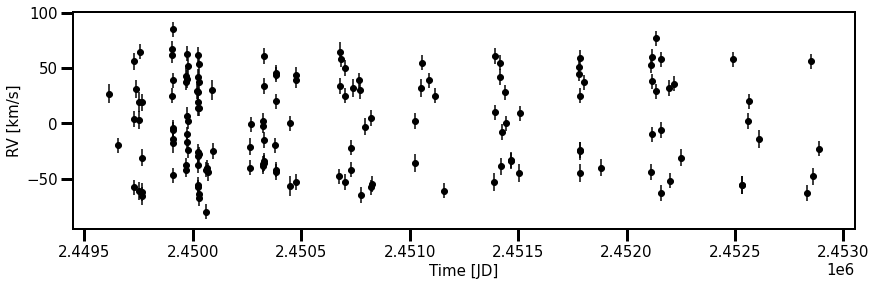

In [209]:
plt.figure(figsize=(14,4))
plt.errorbar(rvs.df['Time'], rvs.df['Vel'], yerr=rvs.df['Err'],
             marker='o', linestyle='', c='k')
plt.xlabel('Time [JD]')
plt.ylabel('RV [km/s]');

In [210]:
rvs.build_confidence_set(minperiod=1.5, maxperiod=20.0)


100%|██████████| 6/6 [00:44<00:00,  7.49s/it]

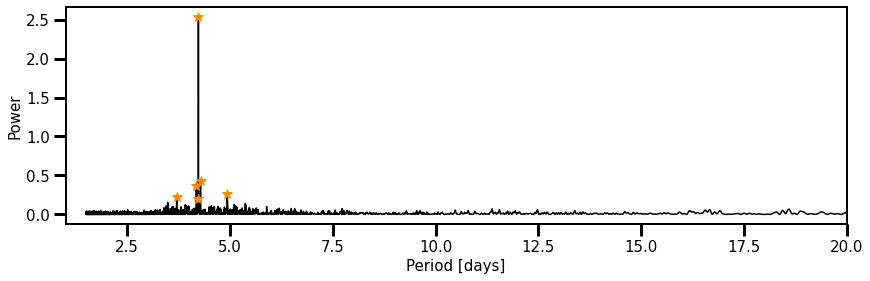

In [211]:
plt.figure(figsize=(14,4))
plt.plot(1.0/rvs.LS_results[0], rvs.LS_results[1], 'k')
_, peak_inds = rvs.get_candidate_periods()
plt.plot(1.0/rvs.LS_results[0][peak_inds], 
         rvs.LS_results[1][peak_inds], 'darkorange', marker='*', ms=10, linestyle='')
plt.xlim(1,20)
plt.xlabel('Period [days]')
plt.ylabel('Power');

In [212]:
rvs.cset ## This still isn't working for some reason

array([4.23073436])

In [213]:
rvs.peak_period

4.230734357127434

In [214]:
lk = LC(rvs.df['Time'], rvs.df['Vel'], flux_err=rvs.df['Err'])
folded = lk.fold(period=rvs.peak_period)

//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:202: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,


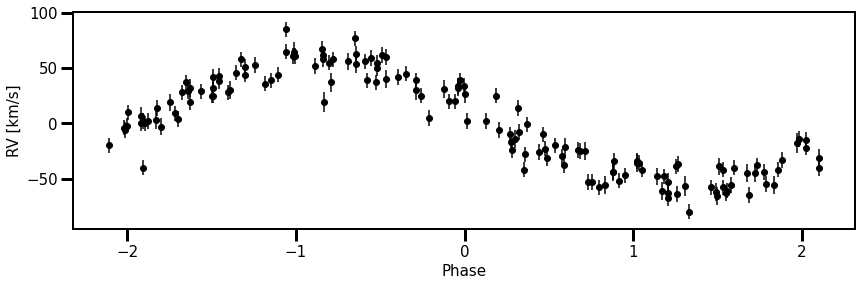

In [215]:
plt.figure(figsize=(14,4))
plt.errorbar(folded.time.value, folded.flux, yerr=folded.flux_err,
             marker='o', c='k', linestyle='')
plt.xlabel('Phase')
plt.ylabel('RV [km/s]');

## Example with Light Curves -- Rotation Periods

### TESS 2-minute Light Curves

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


Text(0, 0.5, 'Normalized Flux')

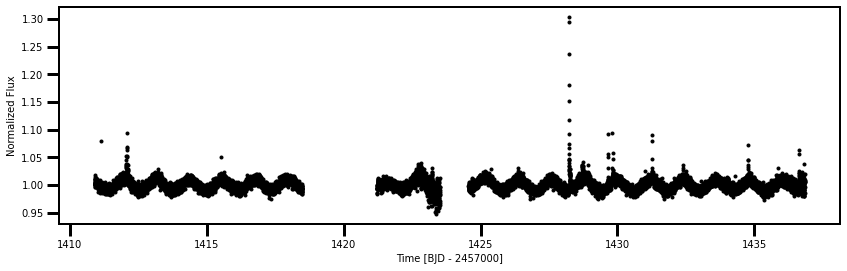

In [74]:
lc = lightkurve.search_lightcurvefile('TIC 44678751', mission='TESS', author='SPOC').download()
lc = lc.normalize().remove_nans()

plt.figure(figsize=(14,4))
plt.plot(lc.time.value, lc.flux, 'k.')
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux')

In [75]:
transit = PeriodicRI(lc.time.value, lc.flux, lc.flux_err)

In [76]:
transit.lomb_scargle(minperiod=0.5, maxperiod=10.0)

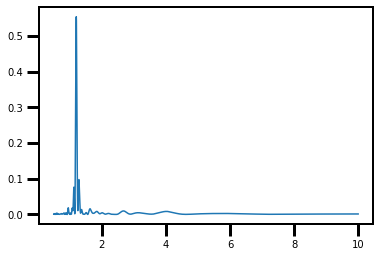

In [77]:
plt.plot(1.0/transit.LS_results[0], transit.LS_results[1])

In [78]:
transit.build_confidence_set(minperiod=0.5, maxperiod=30.0, min_thresh=0.06)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/arcticfox/Documents/GitHub/periodic-ri/periodic_ri/main.py:164: RuntimeWarning: divide by zero encountered in log10
  logL = np.nansum( np.log10(pdf) )
//anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


In [79]:
transit.cset

array([1.20143537])

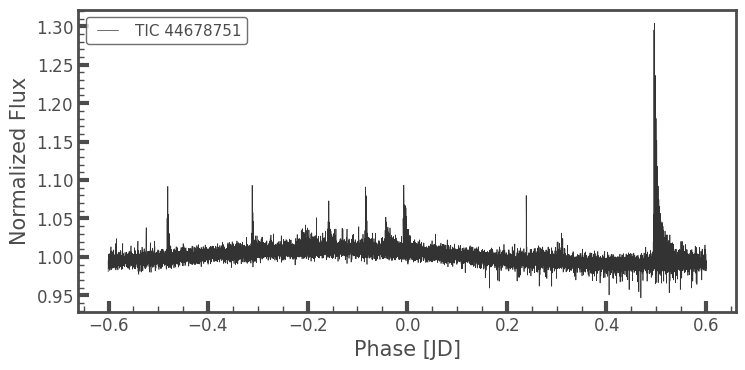

In [80]:
lc.fold(period=transit.cset).plot()

### TESS 30-minute Light Curves

In [180]:
stars = eleanor.multi_sectors(tic=220440079, sectors='all')

data = []
for s in stars:
    data.append(eleanor.TargetData(s))

Found star in Sector(s) 9 10


/Users/arcticfox/Documents/GitHub/eleanor/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")
/Users/arcticfox/Documents/GitHub/eleanor/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")


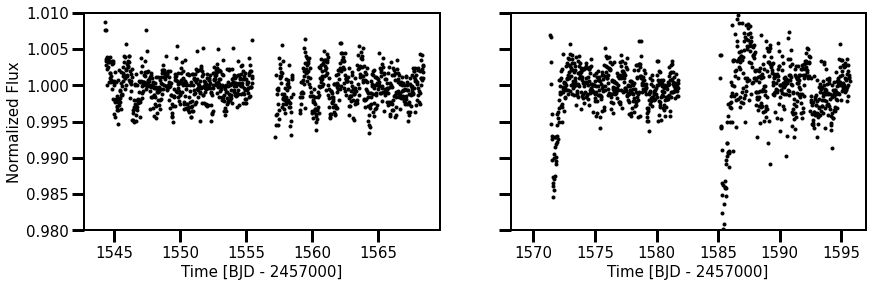

In [181]:
time, flux, err = np.array([]), np.array([]), np.array([])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4), sharey=True)

axes = [ax1, ax2]

for i in range(len(data)):
    q = data[i].quality == 0
    time = np.append(time, data[i].time[q])
    normflux = data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q])
    flux = np.append(flux, normflux)
    err = np.append(err, data[i].flux_err[q])
    
    axes[i].plot(data[i].time[q], normflux, 'k.')

ax1.set_xlabel('Time [BJD - 2457000]')
ax2.set_xlabel('Time [BJD - 2457000]')
ax1.set_ylabel('Normalized Flux')
plt.ylim(0.98, 1.01);

In [182]:
rotperiod = PeriodicRI(time, flux, err)

(0.0, 25.0)

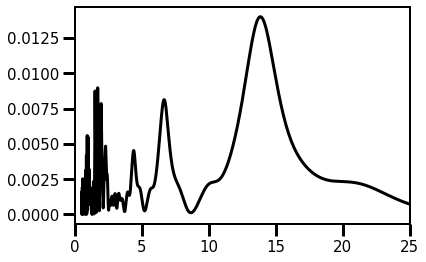

In [183]:
rotperiod.lomb_scargle(minperiod=0.5, maxperiod=30.0)
plt.plot(1.0/rotperiod.LS_results[0], rotperiod.LS_results[1], 'k', lw=3)
plt.xlim(0,25)
#plt.ylim(0,0.05)


In [191]:
rotperiod.build_confidence_set(minperiod=0.5, maxperiod=20.0, 
                               min_thresh=0.005, alpha=0.1, time_budget=2.0)


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

In [192]:
rotperiod.cset

array([13.80230807,  6.6552094 ,  1.69269152,  1.49483808,  0.97148075])

In [193]:
rotperiod.pvals_m

array([[[13.80230807,  0.44      ,  1.        ,  0.44      ],
        [ 6.6552094 ,  0.85      ,  0.15      ,  0.        ],
        [ 1.69269152,  0.86      ,  0.14      ,  0.        ],
        [ 1.49483808,  0.85      ,  0.15      ,  0.        ],
        [ 0.97148075,  0.88      ,  0.12      ,  0.        ]]])

(0.98, 1.02)

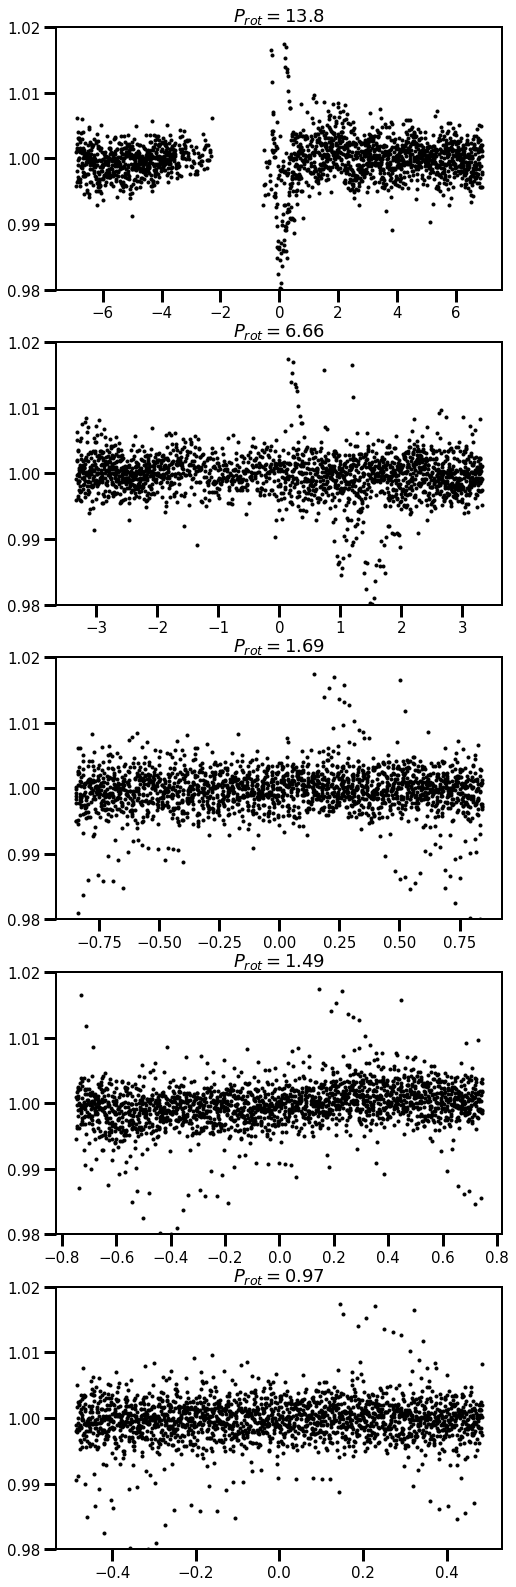

In [216]:
fig, axes = plt.subplots(nrows=len(rotperiod.cset), figsize=(8,28), 
                         sharey=True)
i = 0
for ax in axes.reshape(-1):
    fold = LC(time=time, flux=flux).fold(period=rotperiod.cset[i])
    ax.plot(fold.time.value, fold.flux, 'k.')
    ax.set_title(r'$P_{rot} = $' + str(np.round(rotperiod.cset[i],2)))
    i += 1
plt.ylim(0.98, 1.02)